In [62]:
import numpy as np
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [63]:
class_names = ['Axial', 'Sagittal', 'Coronal']
nClasses = len(class_names)
print("Num classes:", nClasses)

#training images
data_dir = 'MRNet-v1.0/axial-sagittal-coronal-grid'  


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size = (512,512))



val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size = (512,512))
   
class_names = train_ds.class_names
print("Class names", class_names) #class names are organized in alphabetical order


for image_batch, labels_batch in train_ds:
  print("\nImage batch shape",image_batch.shape)
  print("Labels:",labels_batch)
  break



#normalize images
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) 



image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Num classes: 3
Found 3390 files belonging to 3 classes.
Using 2882 files for training.
Found 3390 files belonging to 3 classes.
Using 508 files for validation.
Class names ['axial', 'coronal', 'sagittal']

Image batch shape (32, 512, 512, 3)
Labels: tf.Tensor([2 0 0 1 1 2 1 2 0 1 2 2 0 1 2 1 2 1 1 2 0 2 1 2 1 1 1 1 2 2 1 0], shape=(32,), dtype=int32)
0.0 1.0


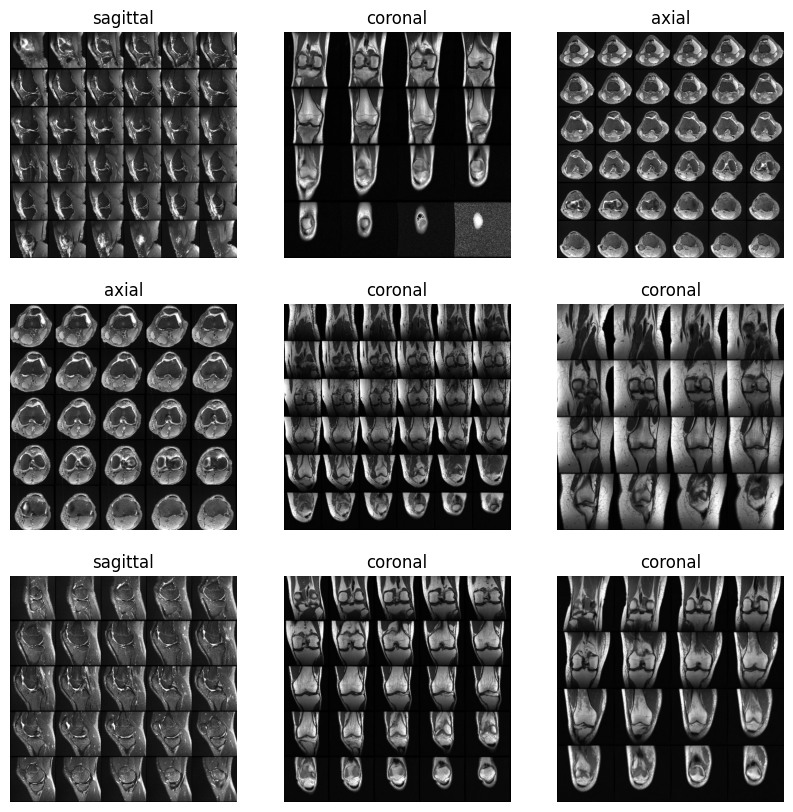

In [64]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")
    
    
    

In [65]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

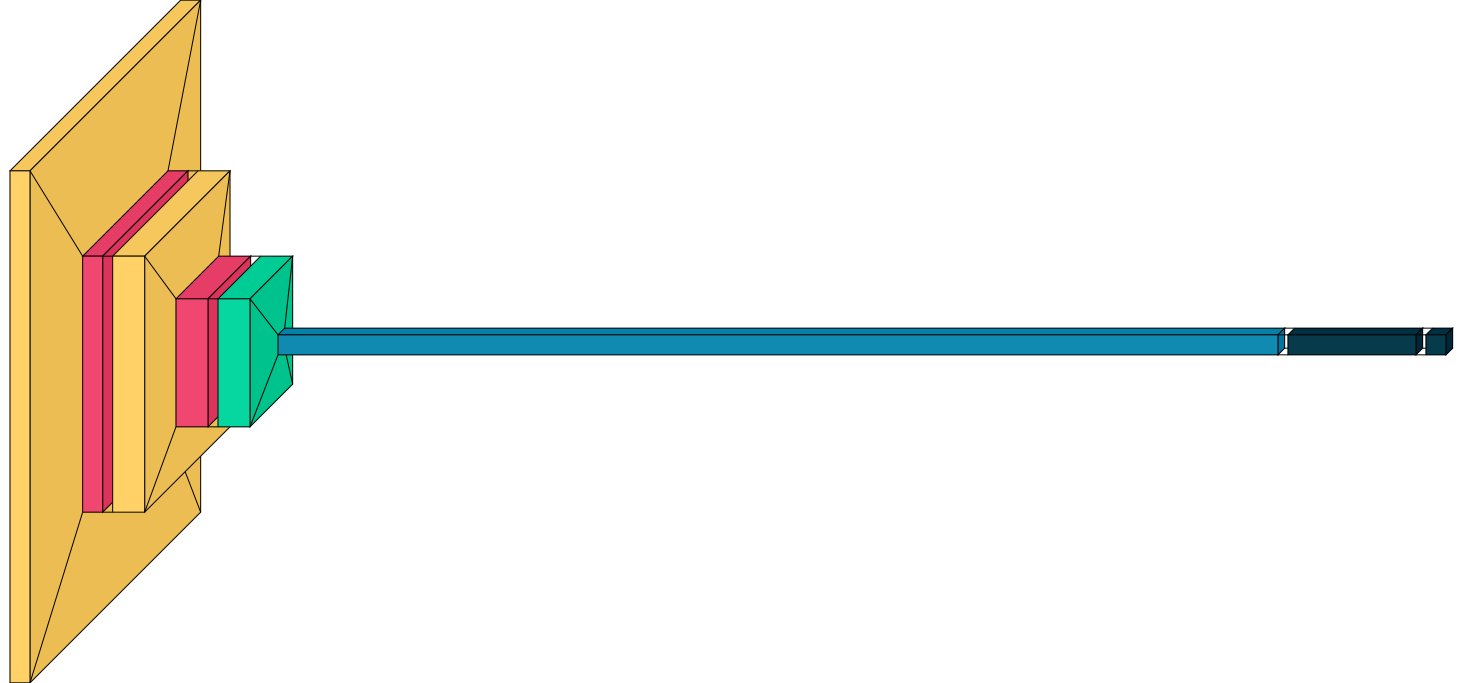

In [121]:
from tensorflow.keras.models import Sequential #functional API exists aswell for fancier stuff
from tensorflow.keras import layers
import visualkeras
from PIL import ImageFont
# font = PIL.ImageFont.load_default()


model = Sequential([
  # data_augmentation,

  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(512,512,3) ),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Conv2D(16, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(nClasses, name="outputs")
])

# model.add(Dense(1, activation='sigmoid')) #for binary classification use this line


# font = "arial.ttf"  # You can use a default font or provide the correct font path
from PIL import ImageFont

visualkeras.layered_view(model, scale_xy=1, scale_z=1, max_z=1000)
# tf.keras.utils.plot_model(model, to_file='tf img classification ex model.svg', show_shapes=True)

In [67]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 256, 256, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 16)      4624      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 64, 64, 16)       

In [68]:
#use some of the training data as test data: 
train_size = int(len(train_ds)*.85) #70% for training
test_size = int(len(train_ds)*.15) #10% for testing might need to add some batches (+...) because int will round down

print(train_size)
print(test_size)

train_ds = train_ds.take(train_size)
test_ds = train_ds.skip(train_size-1).take(test_size) #skips everything already used and taking the rest

77
13


In [69]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


2023-11-26 17:20:52.285510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:342: Filling up shuffle buffer (this may take a while): 34 of 1000
2023-11-26 17:21:05.547005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


77/77 [==============================] - 217s 2s/step - loss: 0.3643 - accuracy: 0.9133 - val_loss: 0.0318 - val_accuracy: 0.9862
Epoch 2/5
77/77 [==============================] - 187s 2s/step - loss: 0.0122 - accuracy: 0.9959 - val_loss: 0.0173 - val_accuracy: 0.9921
Epoch 3/5
77/77 [==============================] - 185s 2s/step - loss: 0.0109 - accuracy: 0.9971 - val_loss: 0.0125 - val_accuracy: 0.9941
Epoch 4/5
77/77 [==============================] - 185s 2s/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0062 - val_accuracy: 0.9980
Epoch 5/5
77/77 [==============================] - 193s 2s/step - loss: 0.0084 - accuracy: 0.9971 - val_loss: 0.0521 - val_accuracy: 0.9823


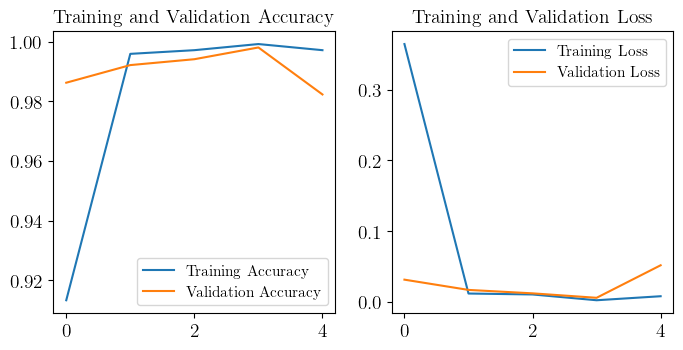

In [70]:
from matplotlib import rc
usetex = True
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize = 14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(prop={'size': 11})
ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
# plt.axis('scaled')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize = 14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(prop={'size': 11})
ax = plt.gca()
ax.set_box_aspect(1)
# ax.set_aspect('equal', adjustable='box')
# plt.axis('scaled')
plt.show()

In [1]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print('\nTest accuracy:', test_acc)




probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_ds)


1/1 [==============================] - 0s 34ms/step


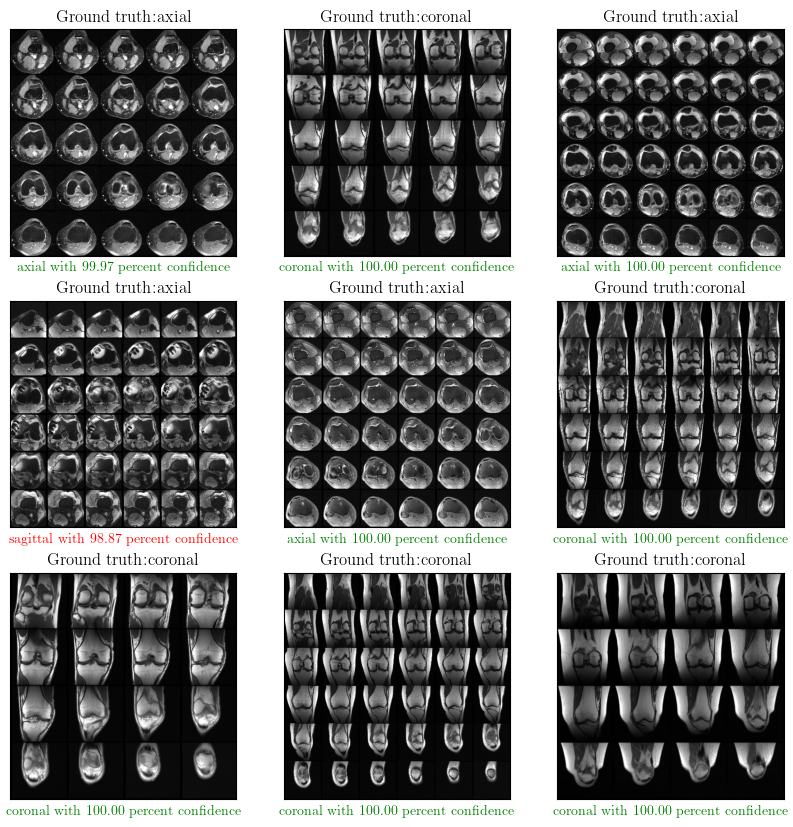

In [123]:
test_image_batch, test_labels_batch = next(iter(test_ds))


test_labels_batch = np.array(test_labels_batch)

# img_array = tf.keras.utils.img_to_array(test_image_batch[0])
# img_array = tf.expand_dims(img_array, 0) # Create a batch
# prediction = probability_model.predict(img_array)# Create a batch
# print(prediction)
# print(np.argmax(prediction))




plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_image_batch[i].numpy())
    img_array = tf.keras.utils.img_to_array(test_image_batch[i])
    img_array = tf.expand_dims(img_array, 0)
    prediction = probability_model.predict(img_array)# Create a batch
    plt.title("Ground truth:" + str(class_names[test_labels_batch[i]]))
    if class_names[test_labels_batch[i]] == class_names[np.argmax(prediction)]:
        plt.xlabel(str(class_names[np.argmax(prediction)]) + " with {:.2f} percent confidence".format(100 * np.max(prediction)), color = 'g')
    else:
        plt.xlabel(str(class_names[np.argmax(prediction)]) + " with {:.2f} percent confidence".format(100 * np.max(prediction)), color = 'r')
    
    
    




In [115]:
model.save(os.path.join('models','axial-coronal-sagittal-classifier1.h5'))

/Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification/ImageClassification/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('axial-coronal-sagittal-classifier1.tflite', 'wb') as f:
  f.write(tflite_model)